In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, LeakyReLU

In [2]:
mnist = tf.keras.datasets.mnist

(X, y), (X_test, y_test) = mnist.load_data()

X, X_test = X / 255.0 * 2 - 1, X_test / 255.0 * 2 - 1

11490434/11490434 [==============================] - 9s 1us/step


In [3]:
X = X.reshape(-1, 784)

In [4]:
def get_generator (latent_space):
    
    i = Input(shape=(latent_space,))
    x = Dense(256,activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x)
    # x = Dropout(0.2)(x)
    x = Dense(512,activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    # x = Dropout(0.2)(x)
    x = Dense(1024,activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    # x = Dropout(0.3)(x)
    x = Dense(784, activation='tanh')(x)
    
    model = Model(i, x)
    
    return model

In [5]:
def get_discriminator (img_shape):
    
    i = Input(shape=(img_shape,))
    
#     x = Conv2D (32, (3, 3) ) (i)
#     x = MaxPooling2D(2, 2)(x)
#     x = Conv2D (64, (3, 3) ) (x)
#     x = MaxPooling2D(2, 2)(x)
    
#     x = Flatten ()(x)
    
    x = Dense (256, activation=LeakyReLU(alpha=0.2)) (i)
    x = BatchNormalization(momentum=0.7) (x)
    x = Dropout(0.2)(x)
    
    x = Dense (512, activation=LeakyReLU(alpha=0.2)) (x)
    x = BatchNormalization(momentum=0.7) (x)
    x = Dropout (0.2) (x)
    
    x = Dense (1, activation='sigmoid') (x)

    model = Model (i, x)
    
    return model

In [6]:
latent_space = 100
generator = get_generator(100)
discriminator = get_discriminator(784)

In [7]:
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

In [8]:
def get_gan (latent_space):

    discriminator.trainable = False
    inputs = Input (shape=(latent_space,))
    img = generator(inputs)

    pred_d = discriminator(img)

    model = Model (inputs, pred_d)
    return model

In [9]:
gan = get_gan (latent_space)

gan.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

In [10]:
batch_size = 32
epochs = 30000
period = 1000

In [11]:
ones = np.ones(batch_size//2)
zeros = np.zeros(batch_size//2)

In [12]:
g_losses = []
d_losses = []

In [13]:
def save_img (epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_space)
    imgs = generator.predict(noise)

    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(28, 28), cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

In [14]:
for epoch in range(epochs):

    noise = np.random.randn(batch_size//2, latent_space)
    x_false, false = generator.predict(noise), [0]*(batch_size//2)
    
    idx = np.random.randint(0, X.shape[0], batch_size//2)
    x_true, true = X[idx], [1]*(batch_size//2)

    x_final = np.concatenate((x_false, x_true))
    label = np.concatenate((false, true))
    
    d_loss, d_acc = discriminator.train_on_batch(x_final, label)
    
    noise = np.random.randn(batch_size, latent_space)
    ones = [1] * batch_size
    ones = np.array(ones)
    g_loss, g_acc = gan.train_on_batch(noise, ones)  
    noise = np.random.randn(batch_size, latent_space)
    g_loss, g_acc = gan.train_on_batch(noise, ones)    

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    print ("d_acc :", d_acc, "g_acc : ", g_acc, "d_loss : ", d_loss, "g_loss : ", g_loss)
    
    if epoch % period == 0:
        save_img (epoch)

1/1 [==============================] - 0s 354ms/step


d_acc : 0.53125 g_acc :  0.53125 d_loss :  0.955852210521698 g_loss :  0.6877626180648804
1/1 [==============================] - 0s 27ms/step
d_acc : 0.8125 g_acc :  0.25 d_loss :  0.38380932807922363 g_loss :  0.8243873119354248
1/1 [==============================] - 0s 31ms/step
d_acc : 0.875 g_acc :  0.53125 d_loss :  0.26966947317123413 g_loss :  0.8776520490646362
1/1 [==============================] - 0s 27ms/step
d_acc : 1.0 g_acc :  0.15625 d_loss :  0.12396728992462158 g_loss :  1.4698394536972046
1/1 [==============================] - 0s 28ms/step
d_acc : 1.0 g_acc :  0.15625 d_loss :  0.06672389805316925 g_loss :  1.6544249057769775
1/1 [==============================] - 0s 27ms/step
d_acc : 1.0 g_acc :  0.09375 d_loss :  0.03786575794219971 g_loss :  2.187035083770752
1/1 [==============================] - 0s 29ms/step
d_acc : 1.0 g_acc :  0.0625 d_loss :  0.05661700665950775 g_loss :  2.5855765342712402
1/1 [==========

KeyboardInterrupt: 

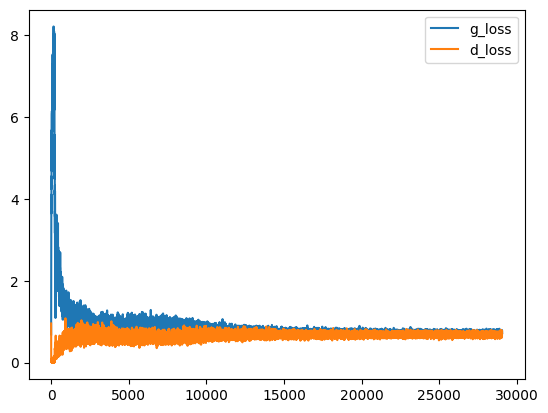

In [21]:
plt.plot(g_losses, label='g_loss')
plt.plot(d_losses, label='d_loss')
plt.legend()